In [107]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [38]:
csv_names = os.listdir("data/")

In [44]:
datetimes=[]
for csv_name in csv_names:
    _dt = datetime.strptime(csv_name[11:-4],'%Y-%m-%d')
    datetimes.append(_dt)
datetimes.sort()

for i in range(len(datetimes)):
    datetimes[i] = csv_names[0][0:11]+datetime.strftime(datetimes[i],'%Y-%m-%d')+".csv"

In [59]:
close_data = np.array([])
for datetime in datetimes:
    _close_data = pd.read_csv("data/"+datetime,header= None)[4].values
    if close_data.shape[0] == 0:
        close_data = _close_data
    else:
        close_data = np.append(close_data,_close_data,axis = 0)

In [64]:
close_data.shape

(57600,)

In [339]:
def to_batch(_arr,_frame_sizes,_stride_size):
    _frames = []
    _targets = []
    _orgs=[]
    for _frame_size in _frame_sizes:
        for i in range(0,_arr.shape[0]-_frame_size,_stride_size):
            _frame = _arr[i:i+_frame_size]
            _org_frame = np.array(_frame)
            _org_frame = _org_frame.reshape(_org_frame.shape+(1,1))
            _org_frame = tf.image.resize(_org_frame,(96,1)).numpy().squeeze()
            _orgs.append(_org_frame)
            
            _frame = _frame.reshape(_frame.shape+(1,1))
            _frame = tf.image.resize(_frame,(96,1)).numpy()
            _frame = _frame.squeeze()
            _frame = (1e-7+_frame - np.min(_frame))/(1e-7+np.max(_frame)-np.min(_frame))
            _frames.append(_frame)

            _target = _arr[i+_frame_size : i+_frame_size + int(_frame_size*0.5)]
            _target = _target.reshape(_target.shape+(1,1))
            _target = tf.image.resize(_target,(32,1)).numpy().squeeze()
            _targets.append(_target)
    return np.array(_frames),np.array(_targets),np.array(_orgs)

In [354]:
frame_sizes = []
for i in range(1,5,1):
    frame_sizes.append(96*i)
stride_size = 8
frames,targets,orgs = to_batch(close_data,frame_sizes,stride_size)

In [296]:
frames.shape,targets.shape

((14340, 96), (14340, 16))

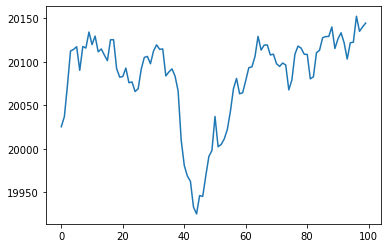

In [297]:
plt.plot(close_data[:100])

In [355]:
frames = (frames-0.5)*2
#targets = targets-targets[:,0].reshape(-1,1)

In [207]:
model_path = os.getcwd()[:-9]+"models/classification_model"

In [282]:
model = keras.models.load_model(model_path,compile = False)

In [356]:
predictions = model.predict(frames)

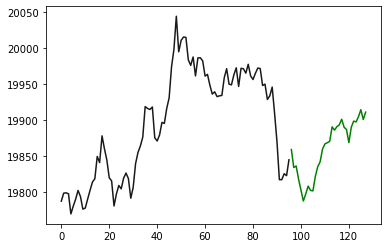

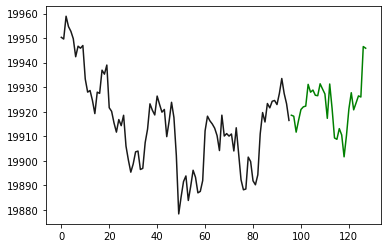

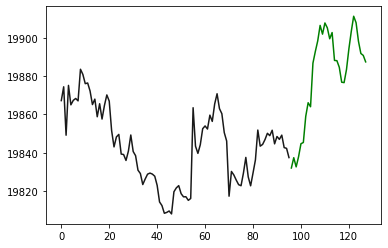

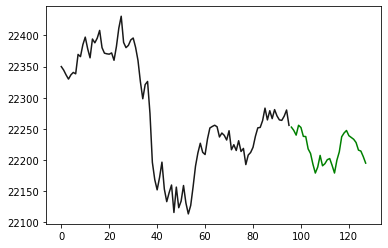

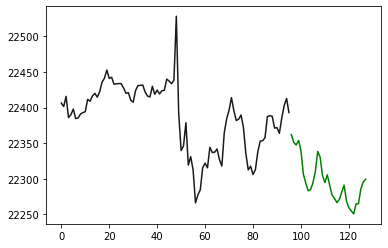

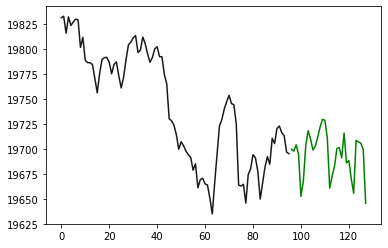

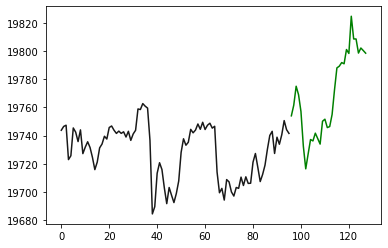

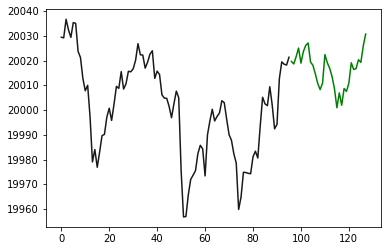

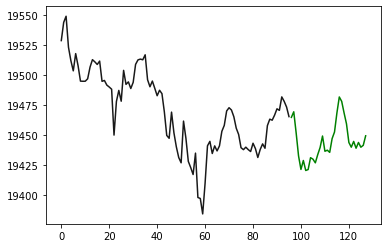

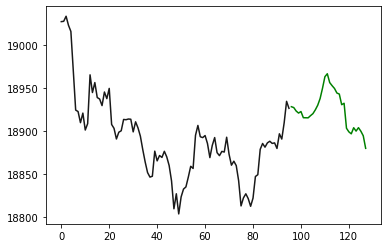

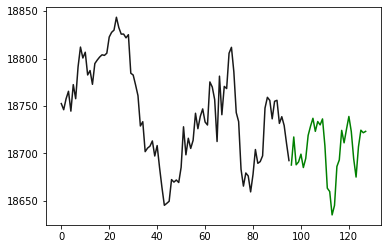

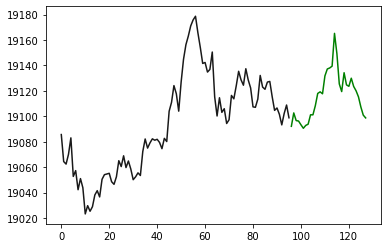

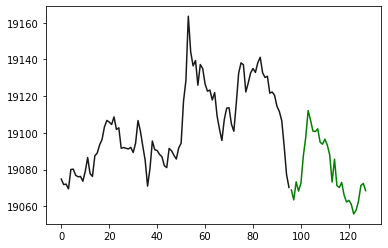

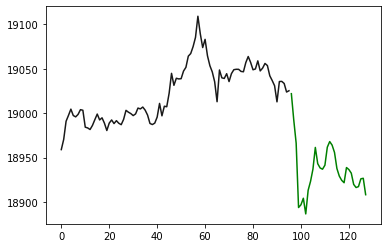

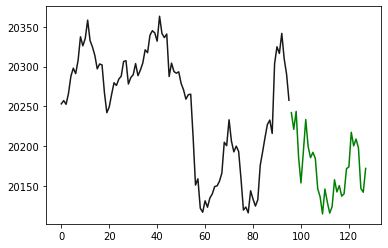

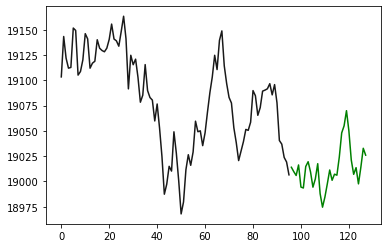

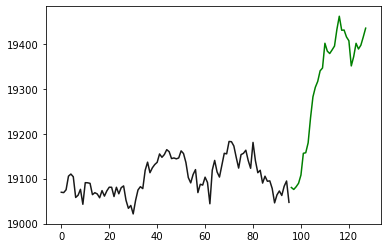

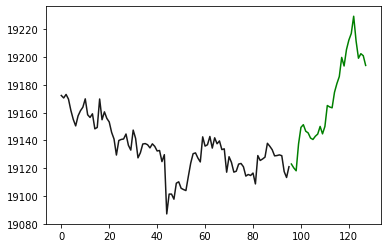

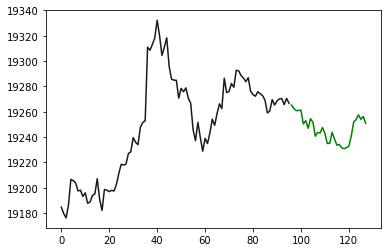

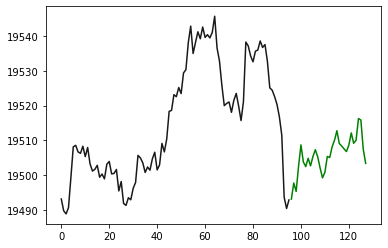

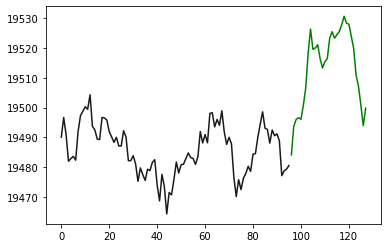

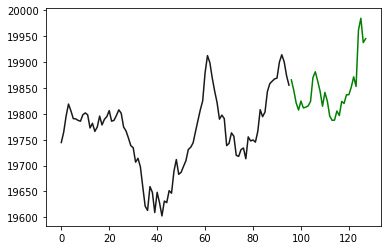

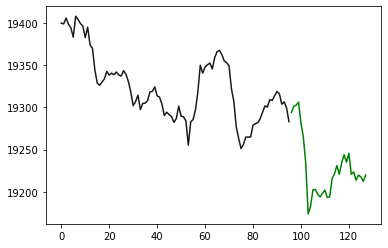

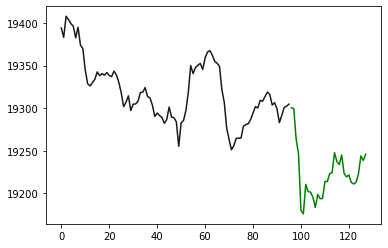

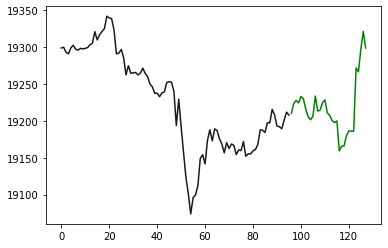

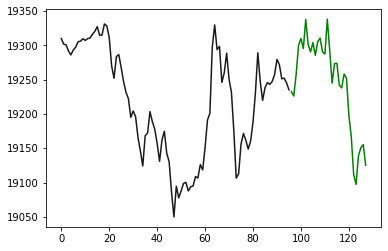

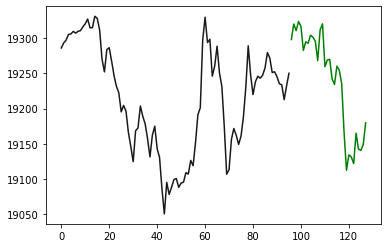

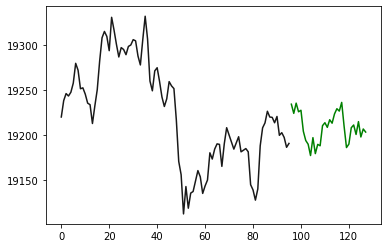

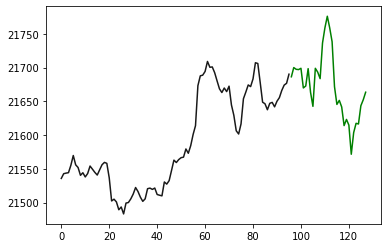

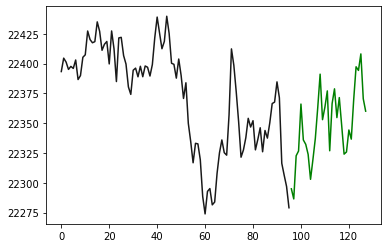

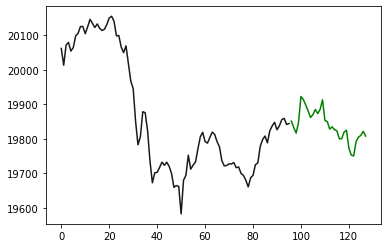

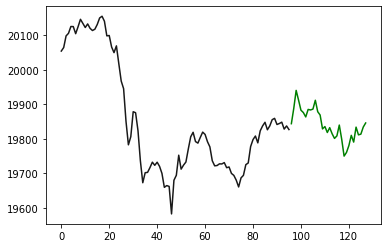

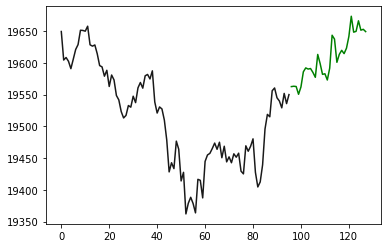

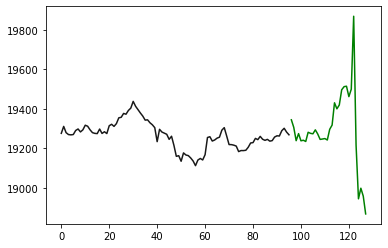

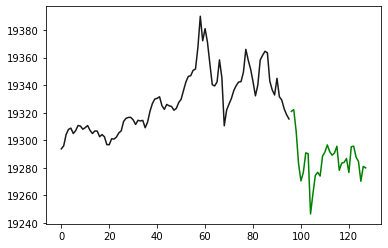

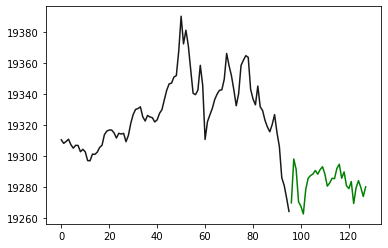

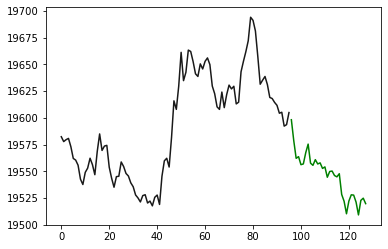

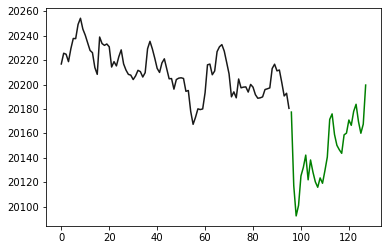

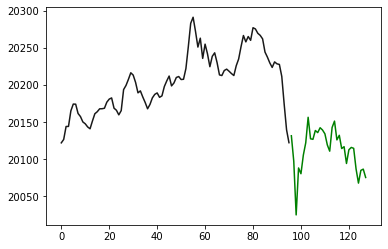

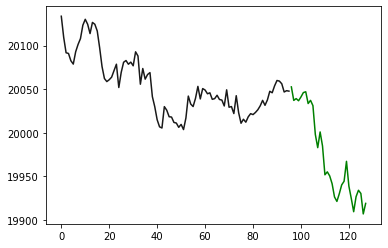

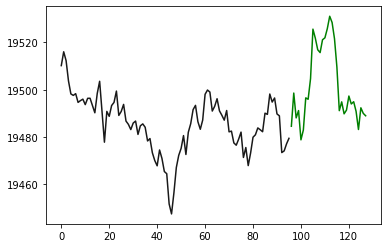

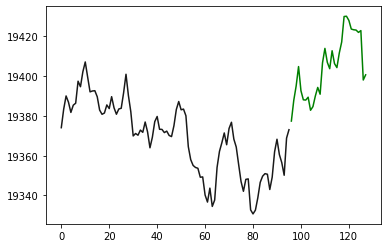

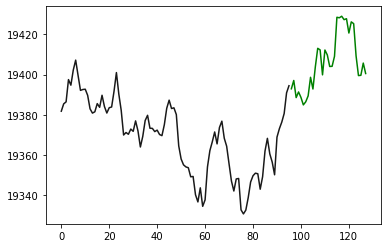

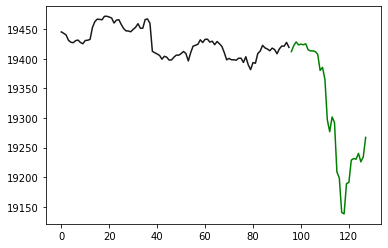

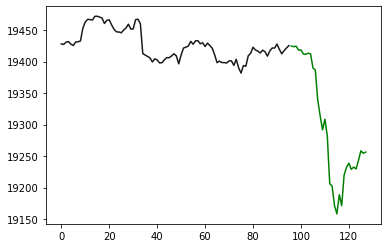

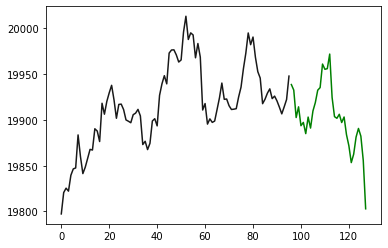

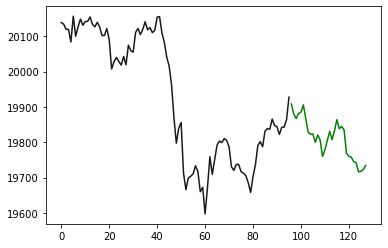

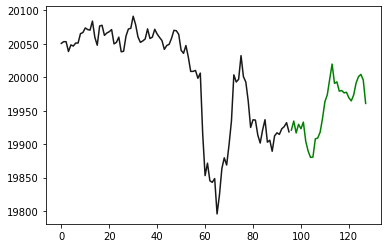

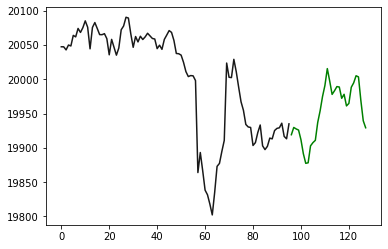

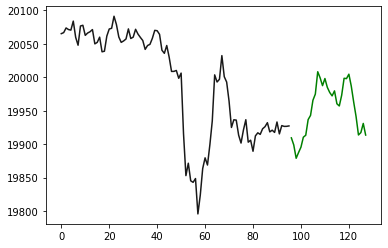

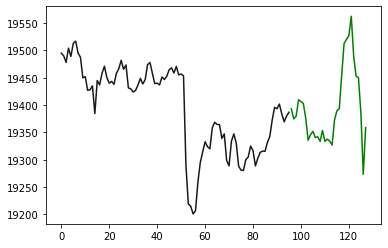

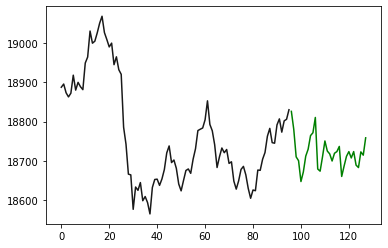

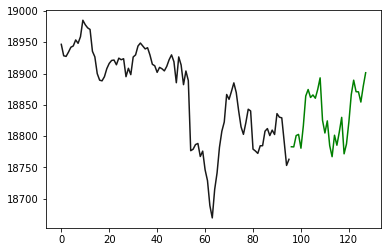

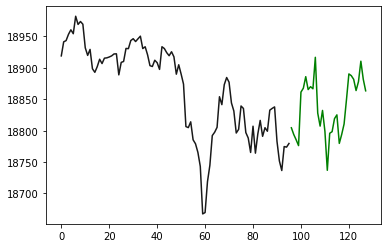

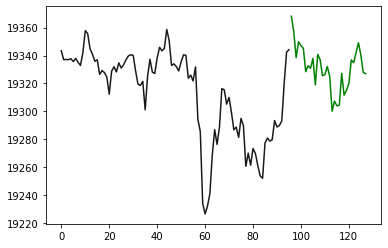

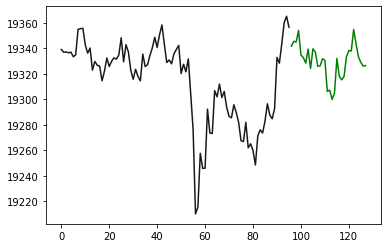

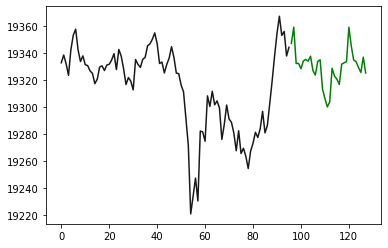

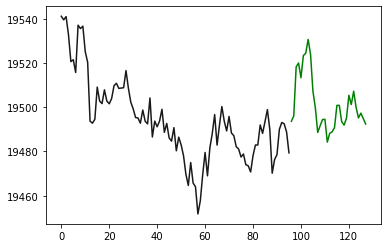

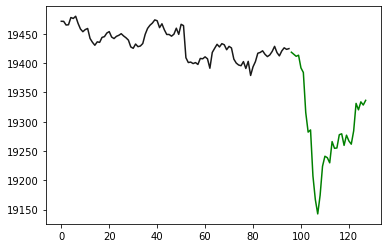

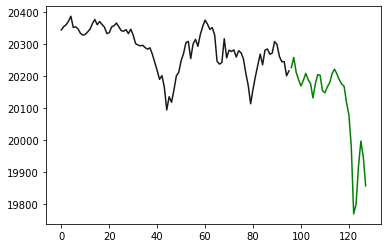

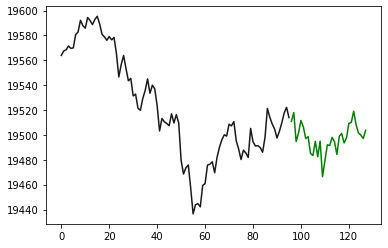

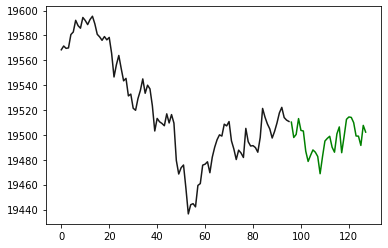

In [361]:
inn = 1
classifications = np.array(predictions[0])
locs = np.array(predictions[1])

tri_indexes = np.where(classifications[:,inn]>0.95)[0]
locs[tri_indexes,1] = locs[tri_indexes,0] + locs[tri_indexes,1]  
tri_loc_indexes = np.where((locs[tri_indexes,1]>0.9 )&(locs[tri_indexes,1]< 0.99 ))[0]
tri_indexes = tri_indexes[tri_loc_indexes]

#plt.ylim([-300,300])
for i in range(tri_indexes.shape[0]):
    plt.plot(orgs[tri_indexes[i]],color="black",alpha=0.9)
    plt.plot(range(96,96+32,1),targets[tri_indexes[i]],color="green")
    #plt.plot(_target,color="black",alpha=0.25)
    plt.show()
    